In [11]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from PyALE import ale
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
import geopandas as gpd
import shap
import numpy as np

In [2]:
file_path = r"ModellingData_V3_PBE_ABE_NE.xlsx"
data = pd.read_excel(file_path)
data.head()

,GEOID,CT_5digit,bphigh,chd,diabetes,highchol,obesity,ABE1,ABE2,ABE3,ABE4,ABE5,ABE6,PBE1,PBE2,NE1,NE2,NE3
0,6037265301,265301,5.761042,0.500960,1.085414,6.762963,11.188110,-0.660764,0.692240,-0.394954,0.925184,-0.829787,0.235442,2.640152,-1.443477,0.059821,-0.053236,15.788235
1,6037401901,401901,16.223067,1.520913,2.788340,21.292775,35.741446,-0.316248,0.295115,-0.205460,0.128051,-0.506879,0.074576,2.905541,-1.458956,1.456775,-0.064177,18.570540
2,6037206020,206020,25.371634,3.241310,7.935621,23.024478,33.083716,-0.378863,0.253378,1.532130,3.858522,-0.640391,-0.504878,-0.537406,0.695641,2.116515,0.113467,18.510373
3,6037265303,265303,24.049650,3.103181,6.206362,23.079906,37.044221,0.275943,4.444663,-0.139991,-0.862088,-0.172616,-0.250905,2.788220,-1.508503,-0.018885,-0.016381,15.746365
4,6037222700,222700,28.248588,3.193318,5.895358,23.581431,49.864896,-0.465064,0.872278,0.292469,1.244664,-0.498661,0.033562,0.603629,-0.112641,1.575785,0.445801,17.049678


In [3]:
data.columns

Index(['GEOID', 'CT_5digit', 'bphigh', 'chd', 'diabetes', 'highchol',
       'obesity', 'ABE1', 'ABE2', 'ABE3', 'ABE4', 'ABE5', 'ABE6', 'PBE1',
       'PBE2', 'NE1', 'NE2', 'NE3'],
      dtype='object')

In [4]:
# Convert relevant object columns to numeric
columns_to_convert = [
    'bphigh', 'chd', 'diabetes', 'highchol', 'obesity',
    'ABE1', 'ABE2', 'ABE3', 'ABE4', 'ABE5', 'ABE6',
    'PBE1', 'PBE2',
    'NE1', 'NE2', 'NE3'
]

data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Select only the columns with float64 data type
float_cols = data.select_dtypes(include=['float64'])

# Fill missing values in float64 columns with the mean of each column
float_cols.fillna(float_cols.mean(), inplace=True)

# Replace the original columns in the DataFrame with the imputed columns
data[float_cols.columns] = float_cols

# Verify that missing values have been filled
print(data.isnull().sum())

GEOID        0
CT_5digit    0
bphigh       0
chd          0
diabetes     0
highchol     0
obesity      0
ABE1         0
ABE2         0
ABE3         0
ABE4         0
ABE5         0
ABE6         0
PBE1         0
PBE2         0
NE1          0
NE2          0
NE3          0
dtype: int64


In [5]:
shapefile = gpd.read_file(r'C:\Users\24652\Desktop\Study area\CENSUS_Tracts.shp') 

In [6]:
# Ensure geoid column names match between the two datasets
data['GEOID'] = data['GEOID'].astype(str)
shapefile['GEOID'] = shapefile['GEOID'].astype(str).str[1:]

In [7]:
# Merge CSV and Shapefile on `geoid`
gdf = shapefile.merge(data, on='GEOID', how='right')

In [8]:
# Define independent variables
independent_vars = [
    'ABE1', 'ABE2', 'ABE3', 'ABE4', 'ABE5', 'ABE6',
    'PBE1', 'PBE2',
    'NE1', 'NE2', 'NE3'
]

# Define dependent variables
dependent_vars = ['bphigh', 'chd', 'diabetes', 'highchol', 'obesity']

# Step 2: Fit Global Random Forest Models and Save Results
importance_results = []

Try 20% --- Waterfall without clip

 99%|===================| 397/400 [01:22<00:00]        

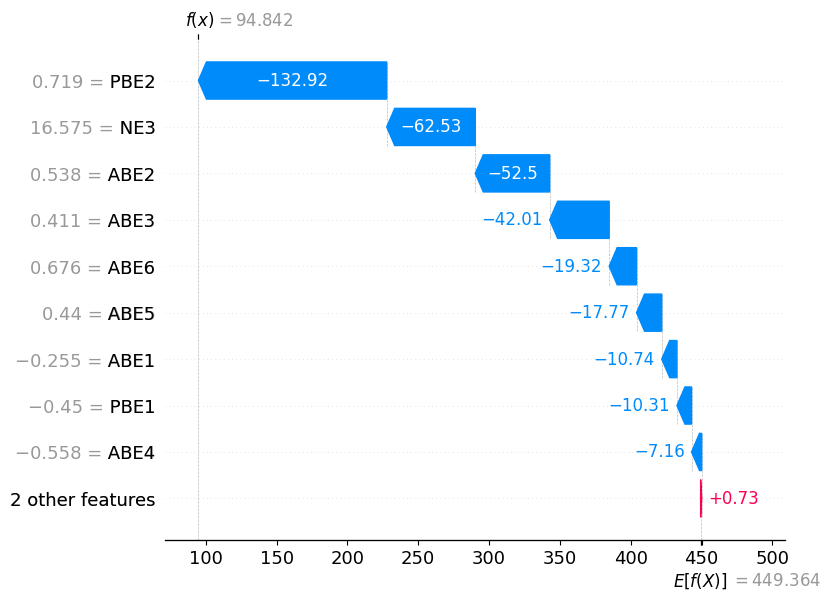

SHAP Waterfall Plot for Dependent Variable: bphigh 20%


100%|===================| 398/400 [01:22<00:00]        

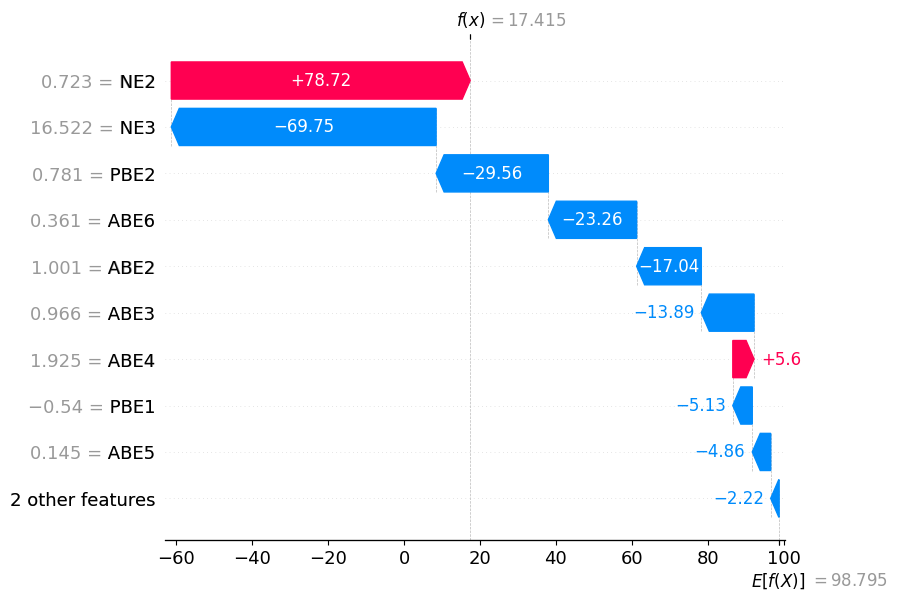

SHAP Waterfall Plot for Dependent Variable: chd 20%


100%|===================| 399/400 [01:24<00:00]        

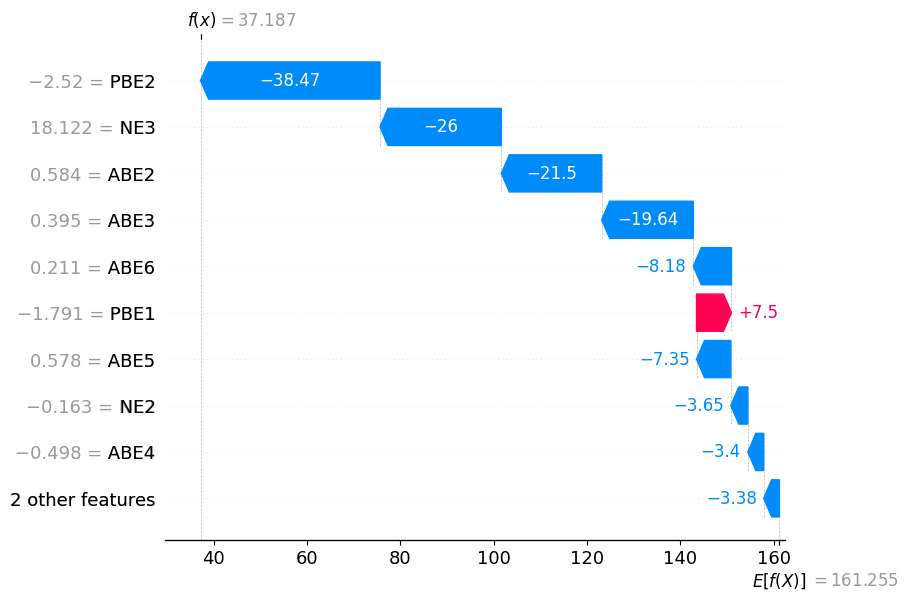

SHAP Waterfall Plot for Dependent Variable: diabetes 20%


 99%|===================| 395/400 [01:22<00:01]        

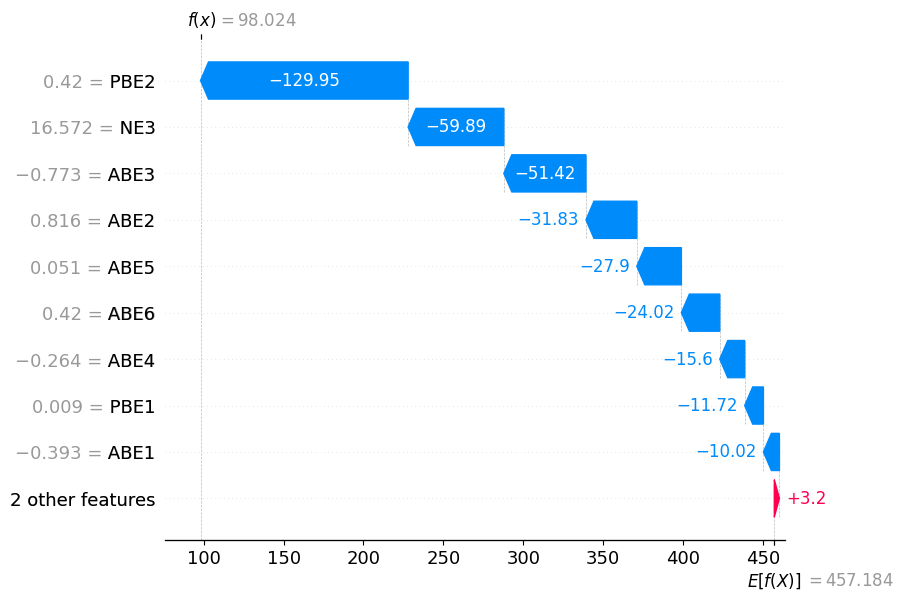

SHAP Waterfall Plot for Dependent Variable: highchol 20%


 99%|===================| 395/400 [01:23<00:01]        

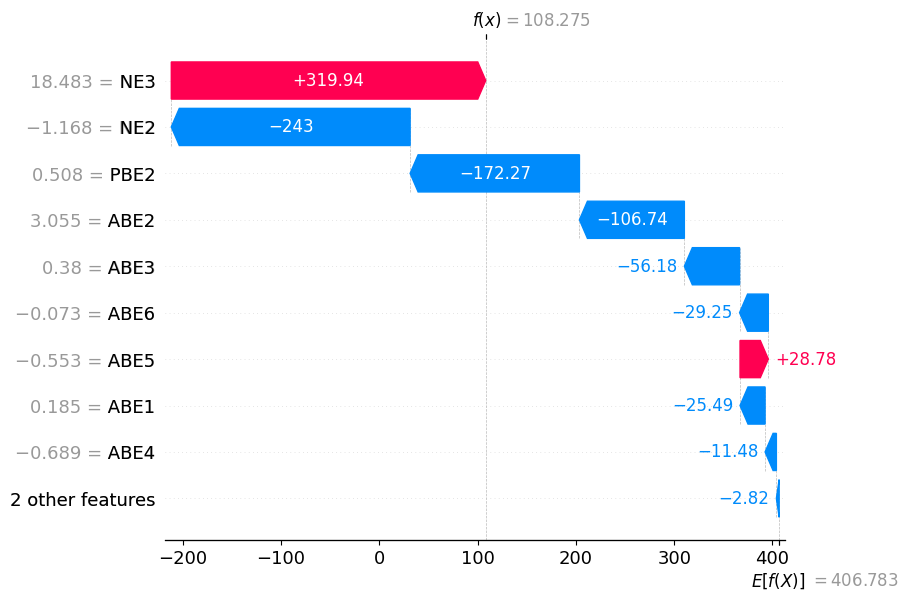

SHAP Waterfall Plot for Dependent Variable: obesity 20%


In [10]:
# Step 1: Filter top 20% for each dependent variable
top_percent = 0.2  # 20%

for dep_var in dependent_vars:
    # Select top 20% of the rows by target value
    threshold = gdf[dep_var].quantile(1 - top_percent)
    top_data = gdf[gdf[dep_var] >= threshold]

    x = top_data[independent_vars]
    y = top_data[dep_var]

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=500, max_features=6, random_state=42)
    rf_model.fit(x, y)

    # SHAP Explanation
    explainer = shap.Explainer(rf_model, x)
    shap_values = explainer(x)

    # Generate Waterfall Plot for the first sample
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0].values,
        base_values=shap_values[0].base_values,
        data=x.iloc[0],
        feature_names=x.columns
    ))

    
    print(f'SHAP Waterfall Plot for Dependent Variable: {dep_var} 20%')
    plt.show()

Try top 20% --- Heatmap Without clip

 99%|===================| 395/400 [01:22<00:01]        

SHAP Heatmap for bphigh (Top 20%)


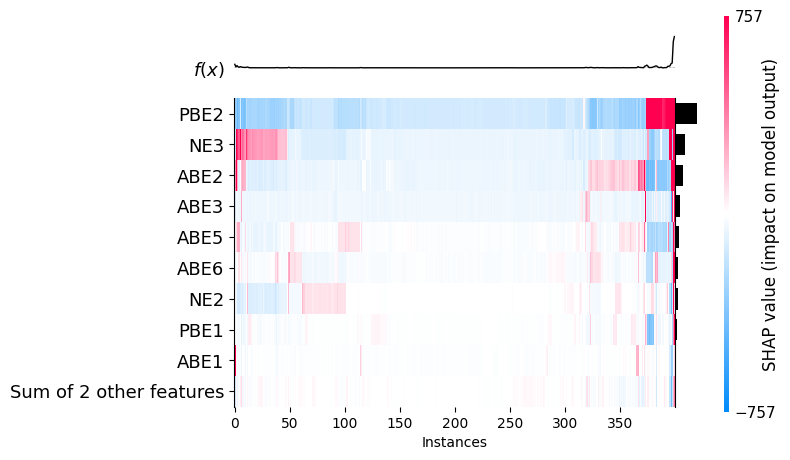

 99%|===================| 396/400 [01:22<00:00]        

SHAP Heatmap for chd (Top 20%)


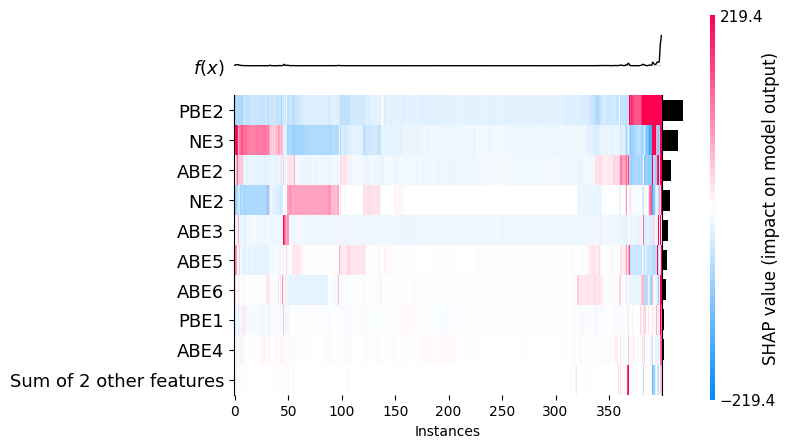

 99%|===================| 396/400 [01:23<00:00]        

SHAP Heatmap for diabetes (Top 20%)


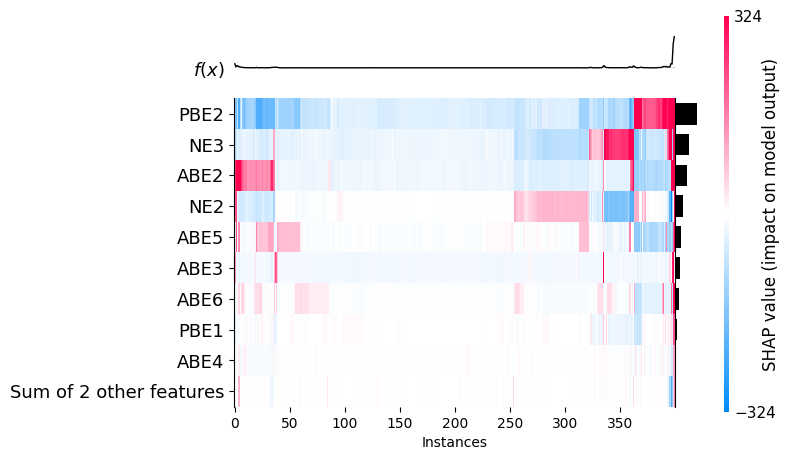

 99%|===================| 397/400 [01:21<00:00]        

SHAP Heatmap for highchol (Top 20%)


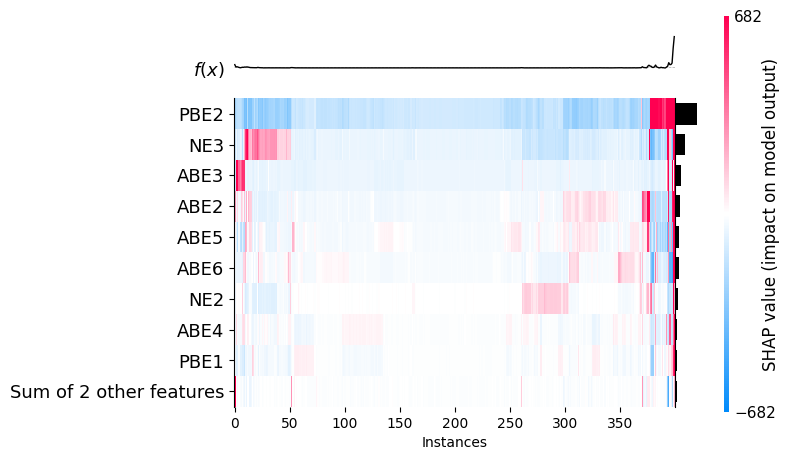

100%|===================| 398/400 [01:23<00:00]        

SHAP Heatmap for obesity (Top 20%)


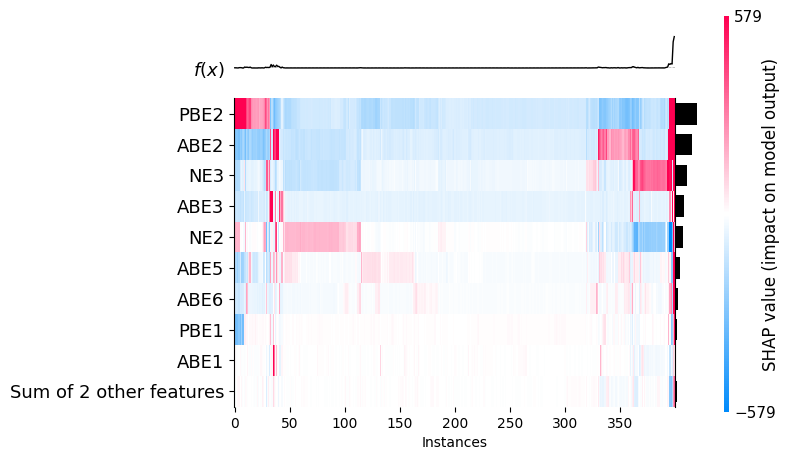

In [11]:
top_percent = 0.2  # Top 20%

for dep_var in dependent_vars:
    # Step 1: Select top 20% rows for the current disease
    threshold = gdf[dep_var].quantile(1 - top_percent)
    top_data = gdf[gdf[dep_var] >= threshold]

    x = top_data[independent_vars]
    y = top_data[dep_var]

    # Step 2: Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=500, max_features=6, random_state=42)
    rf_model.fit(x, y)

    # Step 3: SHAP Explanation
    explainer = shap.Explainer(rf_model, x)
    shap_values = explainer(x)

    # Step 4: SHAP Heatmap Plot
    shap.plots.heatmap(shap_values, show=False)

    # Add custom title
    print(f"SHAP Heatmap for {dep_var} (Top 20%)")
    plt.tight_layout()
    plt.show()

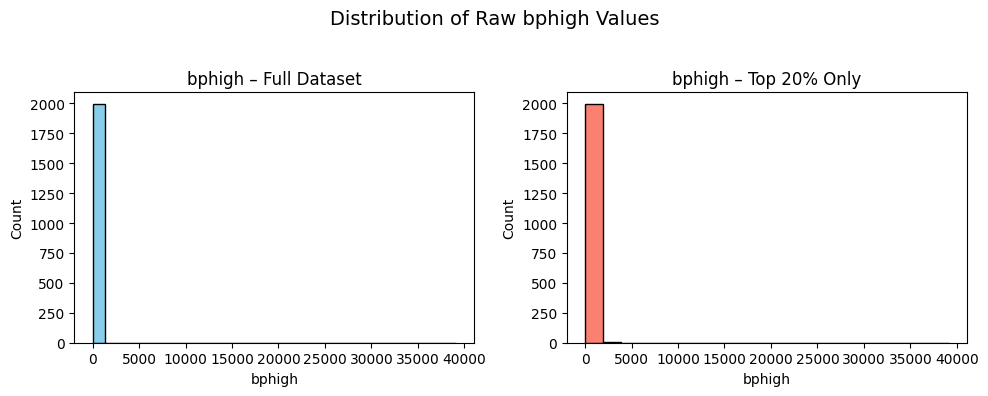

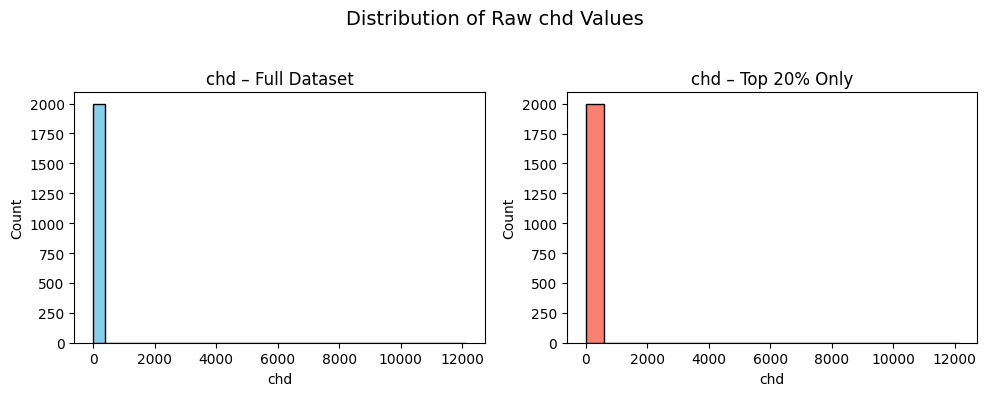

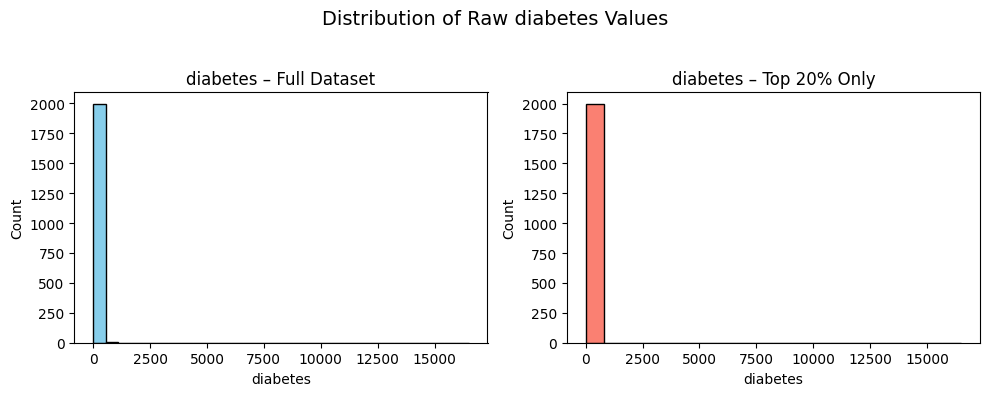

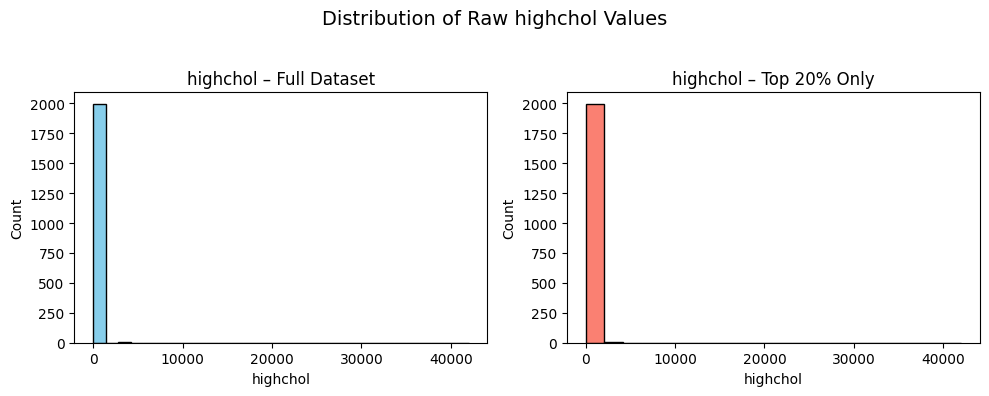

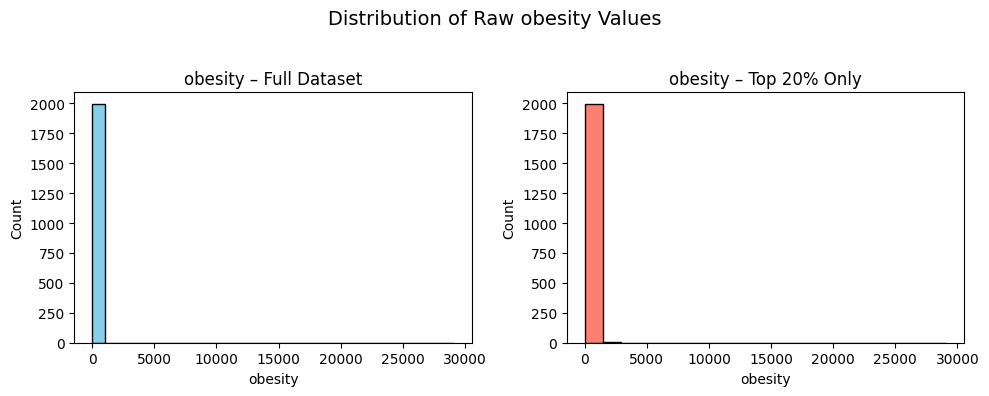

In [13]:
import matplotlib.pyplot as plt

top_percent = 1

for dep_var in dependent_vars:
    values_all = gdf[dep_var].dropna()
    threshold = values_all.quantile(1 - top_percent)
    values_top = values_all[values_all >= threshold]

    plt.figure(figsize=(10, 4))

    # Plot all values
    plt.subplot(1, 2, 1)
    plt.hist(values_all, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"{dep_var} – Full Dataset")
    plt.xlabel(dep_var)
    plt.ylabel("Count")

    # Plot top 20% only
    plt.subplot(1, 2, 2)
    plt.hist(values_top, bins=20, color='salmon', edgecolor='black')
    plt.title(f"{dep_var} – Top 20% Only")
    plt.xlabel(dep_var)
    plt.ylabel("Count")

    plt.suptitle(f"Distribution of Raw {dep_var} Values", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

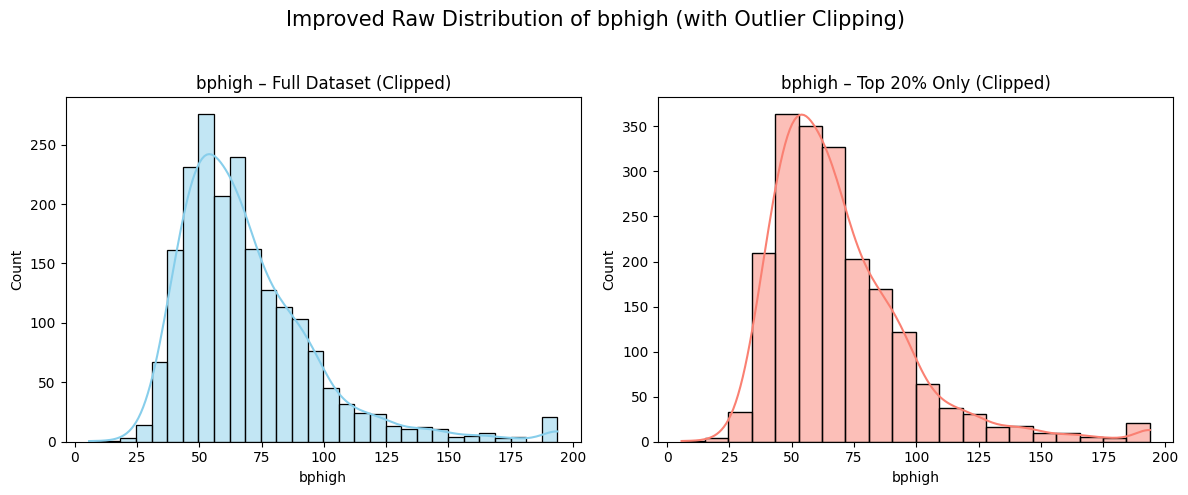

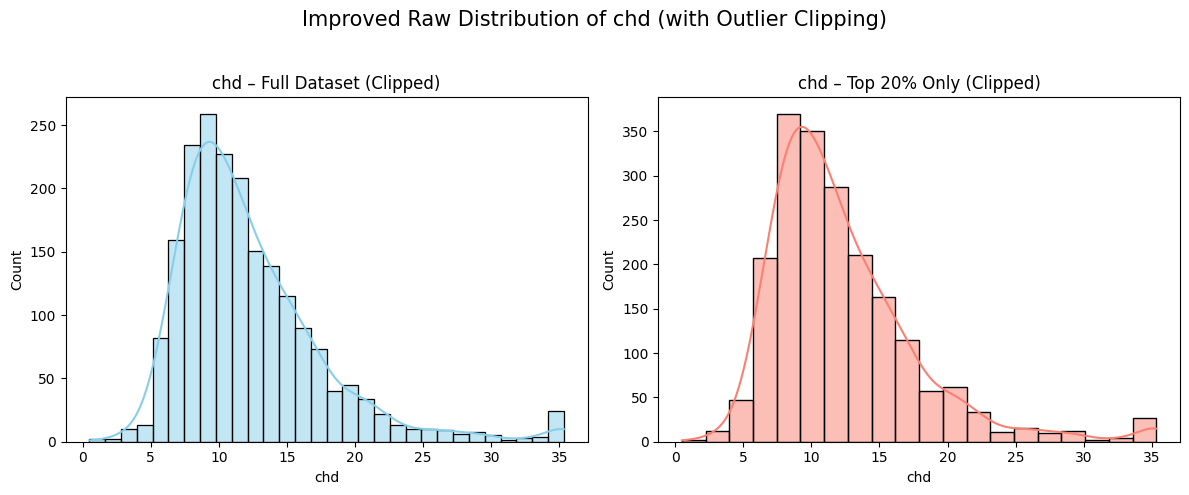

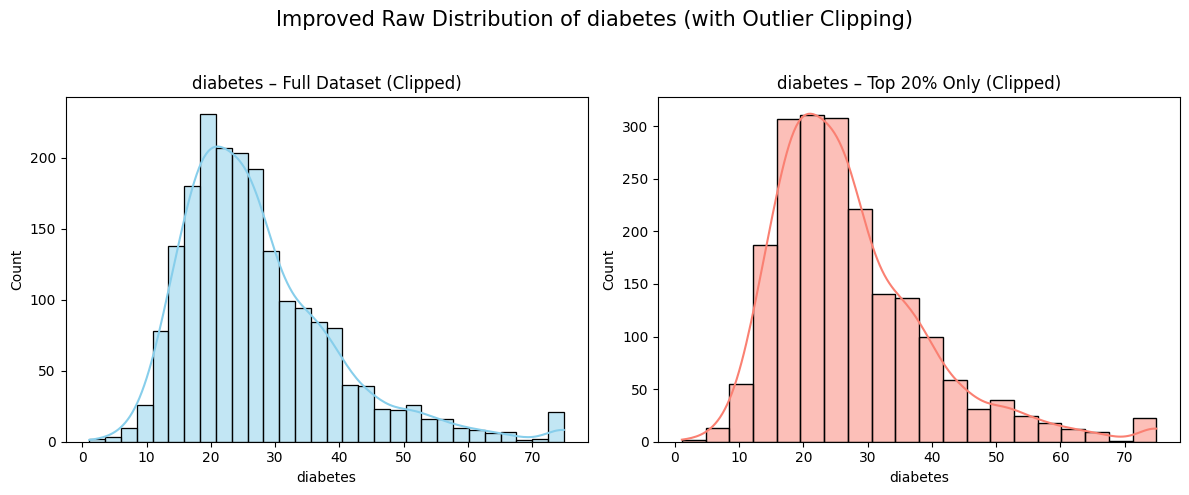

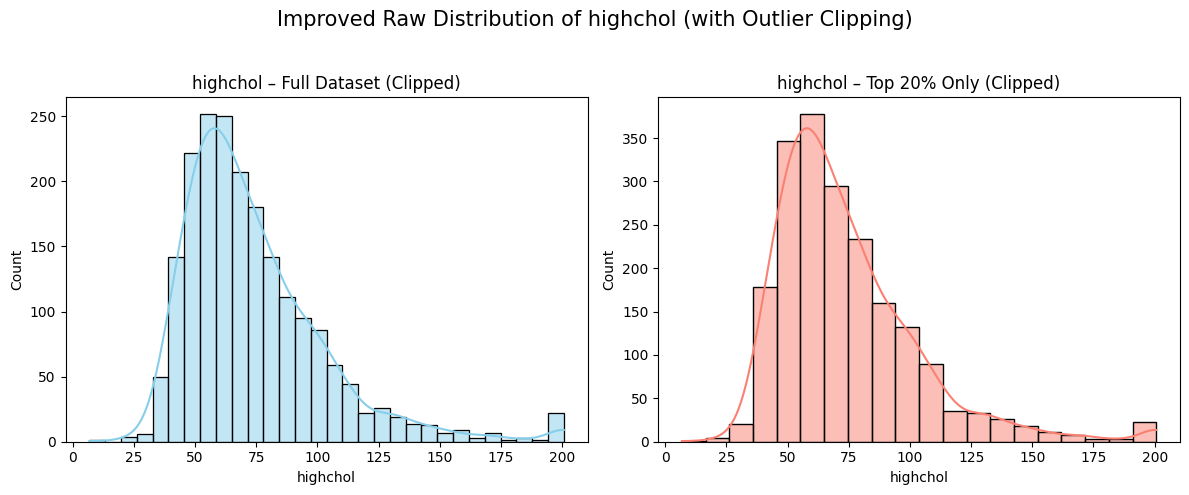

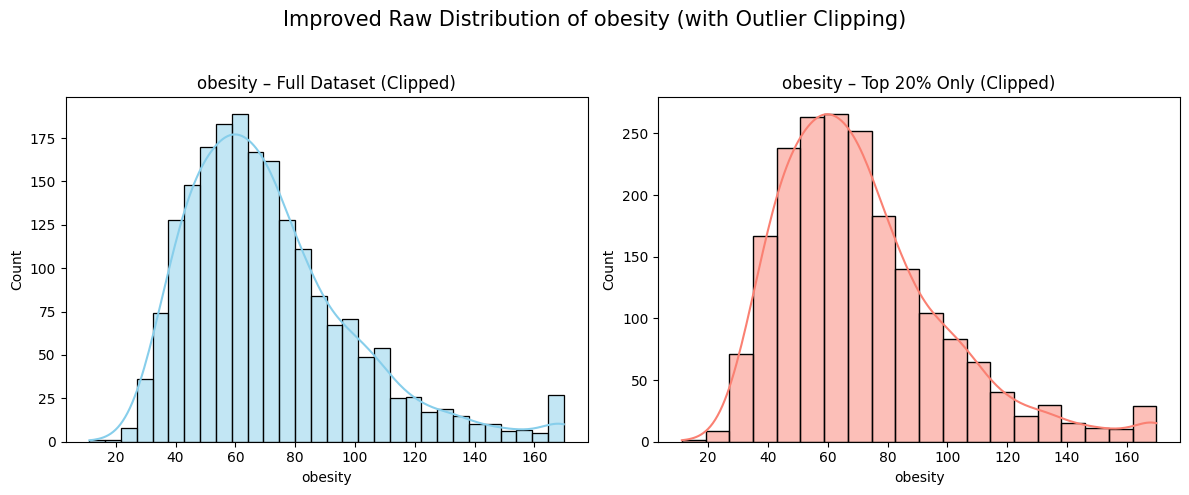

In [14]:
import seaborn as sns
import numpy as np

top_percent = 1

for dep_var in dependent_vars:
    values_all = gdf[dep_var].dropna()

    # Clip the top 1% to handle outliers (for display only)
    clip_threshold = np.percentile(values_all, 99)
    values_all_clipped = values_all.clip(upper=clip_threshold)

    threshold = values_all.quantile(1 - top_percent)
    values_top = values_all[values_all >= threshold]
    values_top_clipped = values_top.clip(upper=clip_threshold)

    plt.figure(figsize=(12, 5))

    # Full dataset
    plt.subplot(1, 2, 1)
    sns.histplot(values_all_clipped, bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"{dep_var} – Full Dataset (Clipped)")
    plt.xlabel(dep_var)
    plt.ylabel("Count")

    # Top 20% only
    plt.subplot(1, 2, 2)
    sns.histplot(values_top_clipped, bins=20, kde=True, color='salmon', edgecolor='black')
    plt.title(f"{dep_var} – Top 20% Only (Clipped)")
    plt.xlabel(dep_var)
    plt.ylabel("Count")

    plt.suptitle(f"Improved Raw Distribution of {dep_var} (with Outlier Clipping)", fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Try all --- clipped 99%, Heatmap 

100%|===================| 1997/1998 [15:38<00:00]        

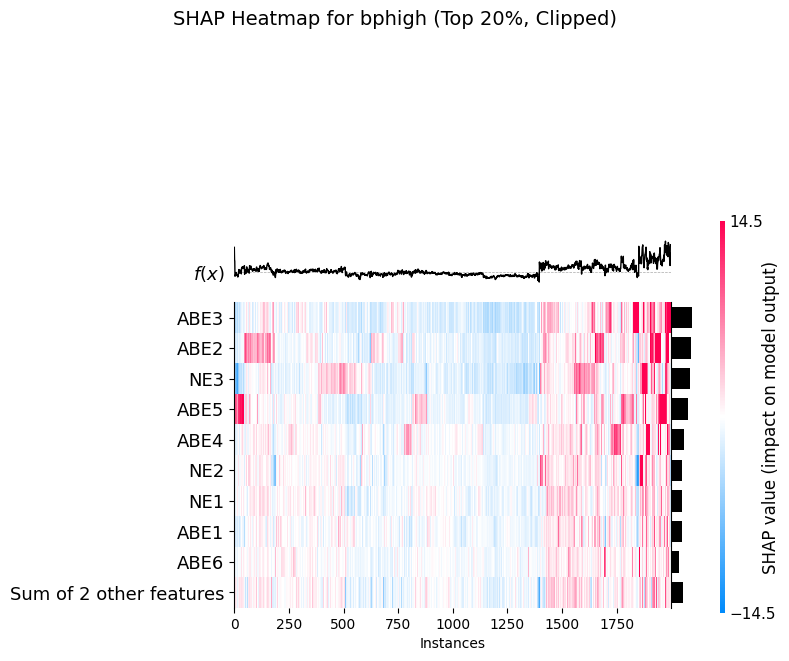

100%|===================| 1996/1998 [15:48<00:00]        

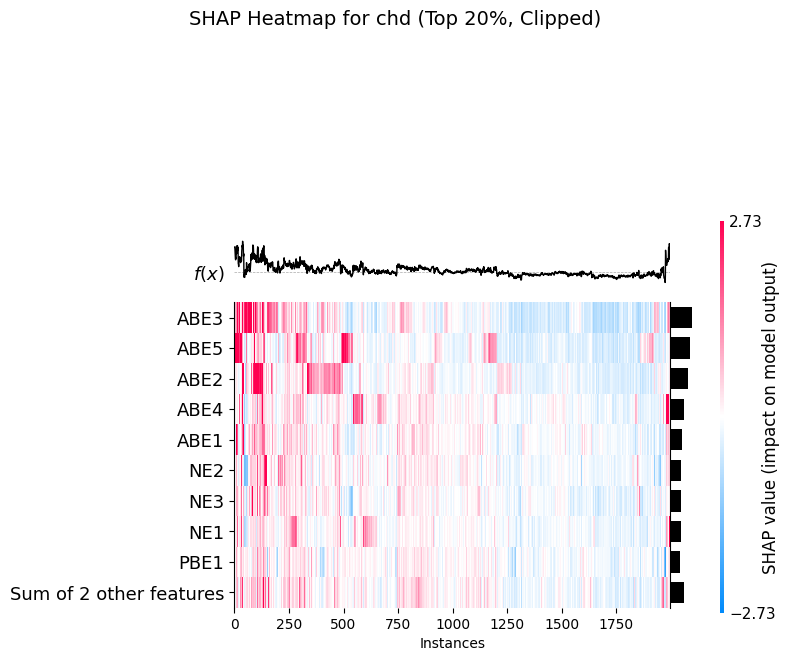

100%|===================| 1996/1998 [17:06<00:01]        

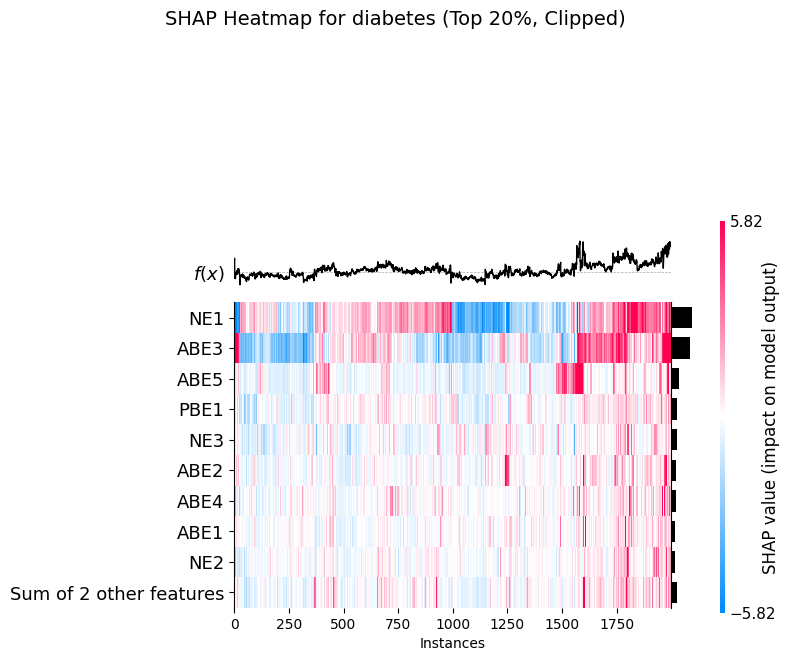

100%|===================| 1997/1998 [15:24<00:00]        

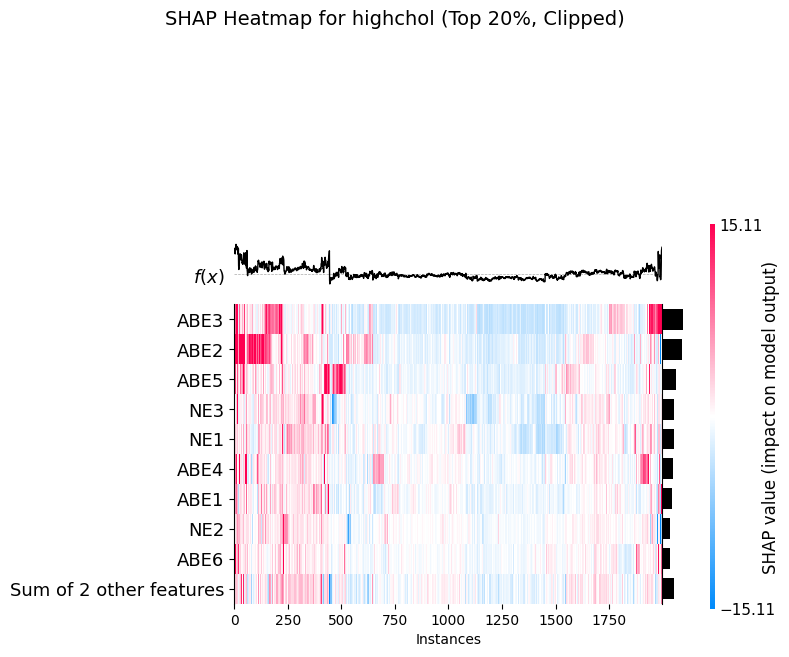

100%|===================| 1997/1998 [16:24<00:00]        

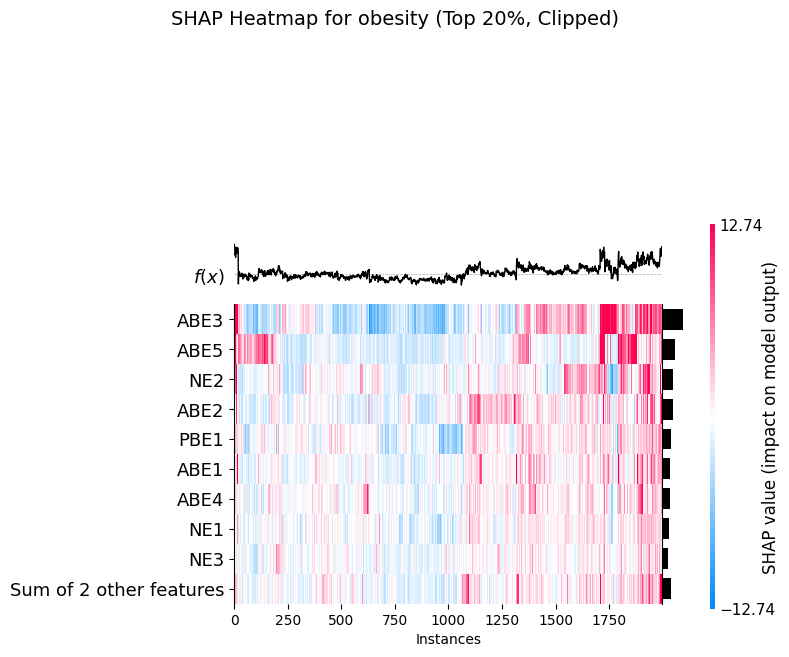

In [15]:
# Clip-out outliers Random forest


from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np

top_percent = 1  

for dep_var in dependent_vars:
    # Step 0: Remove NaNs and clip extreme outliers from the target variable
    y_raw = gdf[dep_var].dropna()
    clip_threshold = np.percentile(y_raw, 99)
    y_clipped = y_raw.clip(upper=clip_threshold)

    # Step 1: Filter all of the clipped values
    threshold = y_clipped.quantile(1 - top_percent)
    top_mask = y_clipped >= threshold
    top_data = gdf.loc[top_mask, independent_vars + [dep_var]].copy()

    # Optional: clip target in top_data just in case
    top_data[dep_var] = top_data[dep_var].clip(upper=clip_threshold)

    # Step 2: Prepare inputs
    x = top_data[independent_vars]
    y = top_data[dep_var]

    # Step 3: Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=500, max_features=6, random_state=42)
    rf_model.fit(x, y)

    # Step 4: SHAP Explanation
    explainer = shap.Explainer(rf_model, x)
    shap_values = explainer(x)

    # Step 5: SHAP Heatmap Plot
    shap.plots.heatmap(shap_values, show=False)
    plt.gcf().suptitle(f"SHAP Heatmap for {dep_var} (Top 20%, Clipped)", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

Try all --- clipped 99% waterfall (only for one line of data)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np

top_percent = 1  

for dep_var in dependent_vars:
    # Step 0: Clip extreme values in target variable
    y_raw = gdf[dep_var].dropna()
    clip_threshold = np.percentile(y_raw, 99)
    y_clipped = y_raw.clip(upper=clip_threshold)

    # Step 1: Select top all of clipped values
    threshold = y_clipped.quantile(1 - top_percent)
    top_mask = y_clipped >= threshold
    top_data = gdf.loc[top_mask, independent_vars + [dep_var]].copy()
    top_data[dep_var] = top_data[dep_var].clip(upper=clip_threshold)

    x = top_data[independent_vars]
    y = top_data[dep_var]

    # Step 2: Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=500, max_features=6, random_state=42)
    rf_model.fit(x, y)

    # Step 3: SHAP Explanation
    explainer = shap.Explainer(rf_model, x)
    shap_values = explainer(x)

    # Step 4: SHAP Waterfall Plot for the first instance
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0].values,
        base_values=shap_values[0].base_values,
        data=x.iloc[0],
        feature_names=x.columns
    ))

    # Step 5: Add title
    plt.gcf().suptitle(
        f"SHAP Waterfall Plot for {dep_var} (Top 20% Clipped)", fontsize=14, y=1.02
    )
    plt.tight_layout()
    plt.show()


Try all data --- Without clip Heatmap

100%|===================| 1997/1998 [16:02<00:00]        

SHAP Heatmap for bphigh (Top 20%)


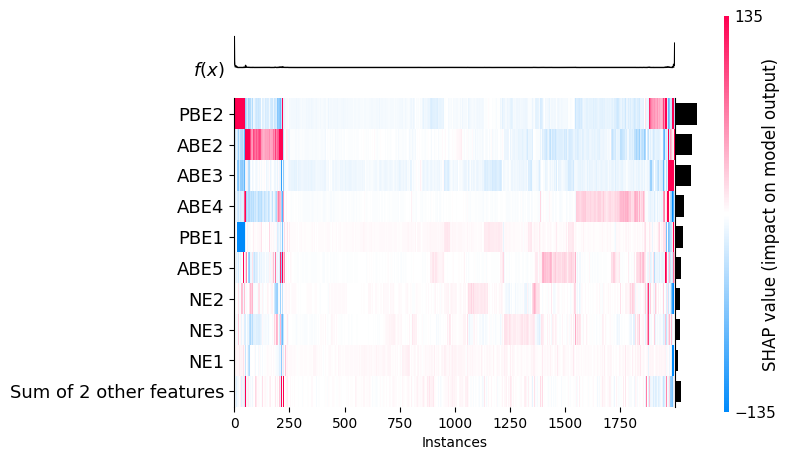

100%|===================| 1997/1998 [15:48<00:00]        

SHAP Heatmap for chd (Top 20%)


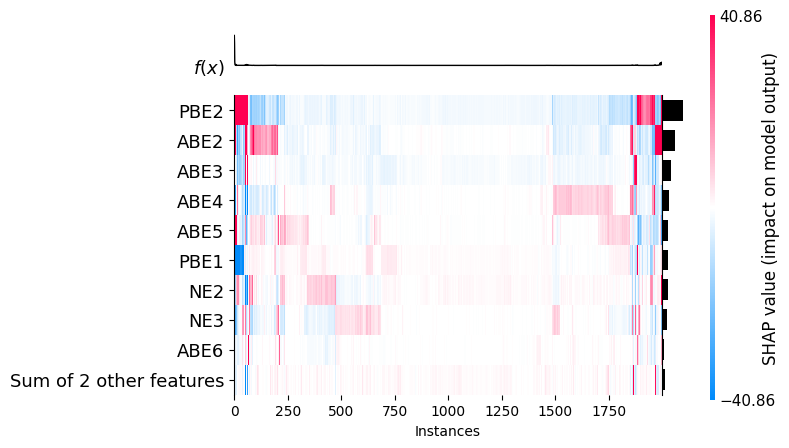

100%|===================| 1996/1998 [16:01<00:00]        

SHAP Heatmap for diabetes (Top 20%)


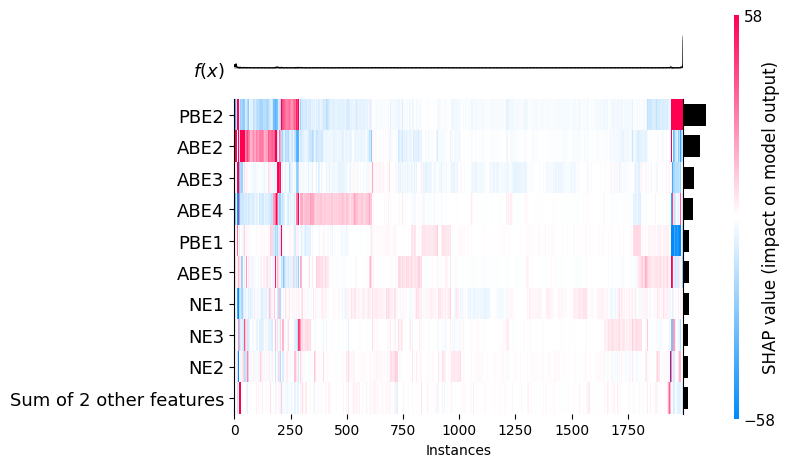

100%|===================| 1997/1998 [15:14<00:00]        

SHAP Heatmap for highchol (Top 20%)


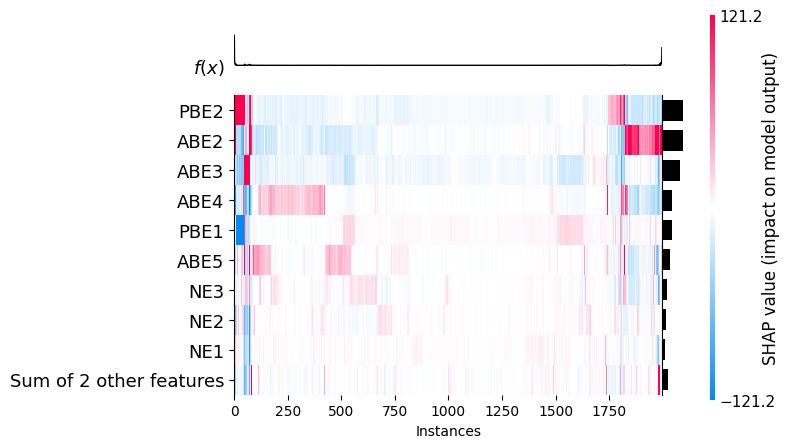

100%|===================| 1996/1998 [16:11<00:00]        

SHAP Heatmap for obesity (Top 20%)


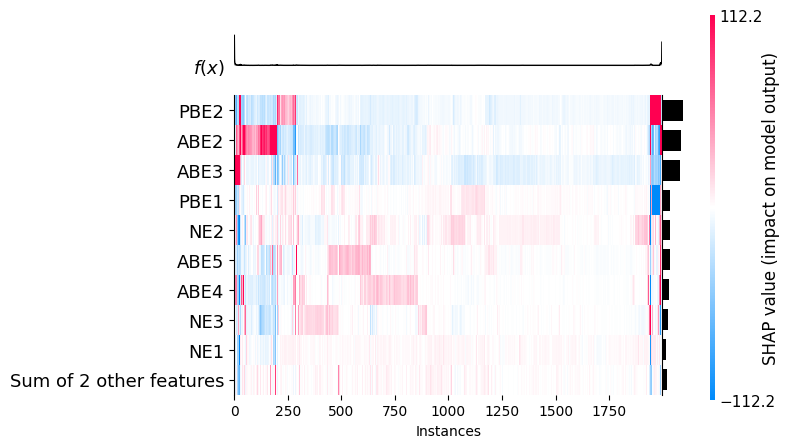

In [11]:
top_percent = 1

for dep_var in dependent_vars:
    # Step 1: Select all rows for the current disease
    threshold = gdf[dep_var].quantile(1 - top_percent)
    top_data = gdf[gdf[dep_var] >= threshold]

    x = top_data[independent_vars]
    y = top_data[dep_var]

    # Step 2: Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=500, max_features=6, random_state=42)
    rf_model.fit(x, y)

    # Step 3: SHAP Explanation
    explainer = shap.Explainer(rf_model, x)
    shap_values = explainer(x)

    # Step 4: SHAP Heatmap Plot
    shap.plots.heatmap(shap_values, show=False)

    # Add custom title
    print(f"SHAP Heatmap for {dep_var} ")
    plt.tight_layout()
    plt.show()

Try all data --- without clip, waterfall

100%|===================| 1996/1998 [15:41<00:00]        

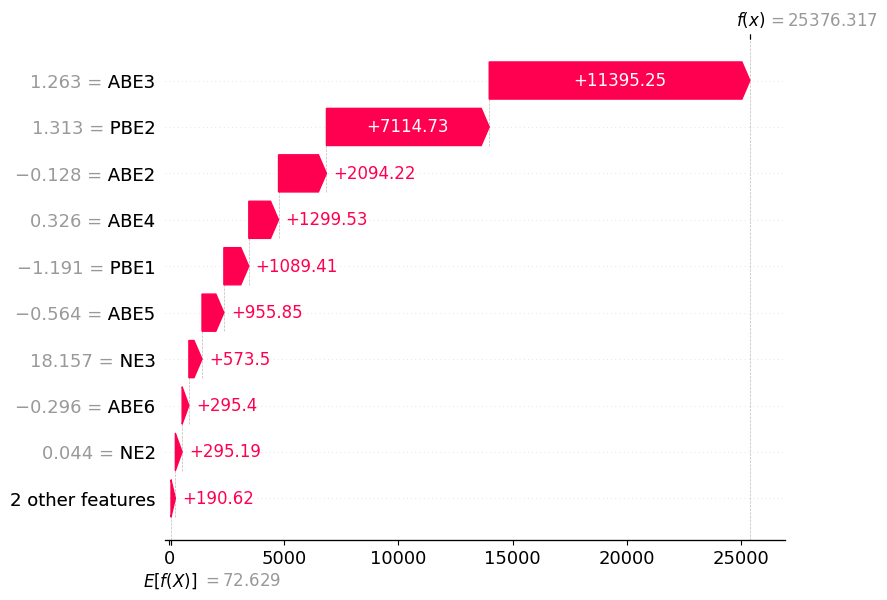

SHAP Waterfall Plot for Dependent Variable: bphigh


100%|===================| 1996/1998 [15:51<00:00]        

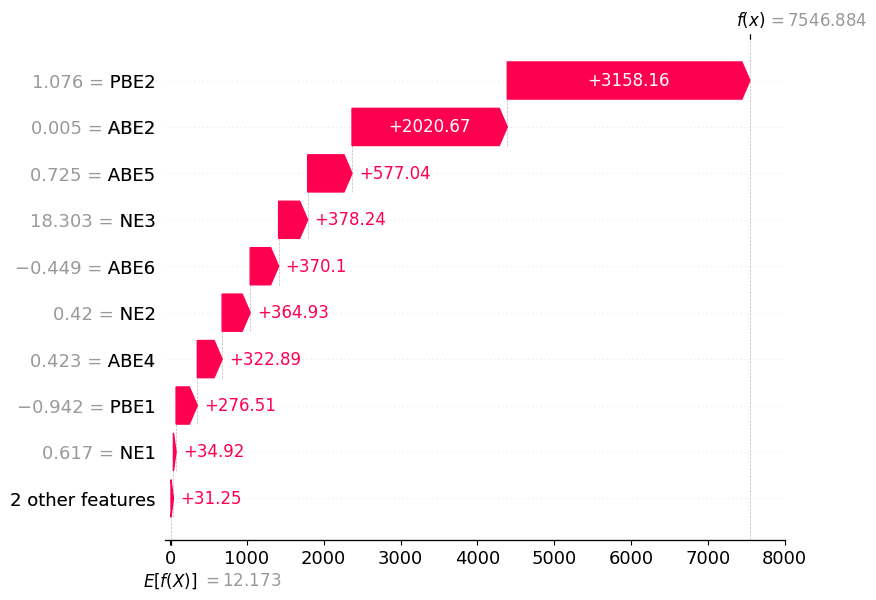

SHAP Waterfall Plot for Dependent Variable: chd


100%|===================| 1996/1998 [16:32<00:00]        

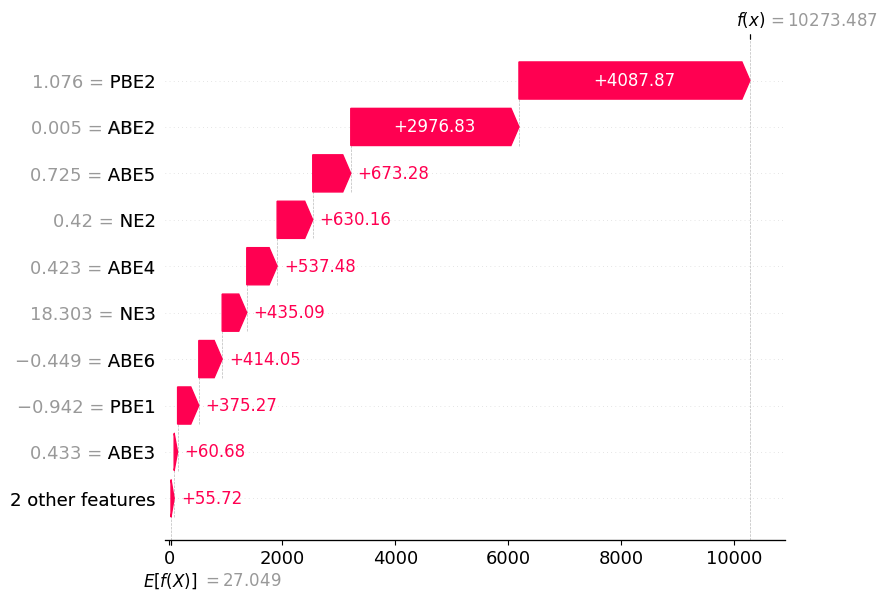

SHAP Waterfall Plot for Dependent Variable: diabetes


100%|===================| 1997/1998 [15:49<00:00]        

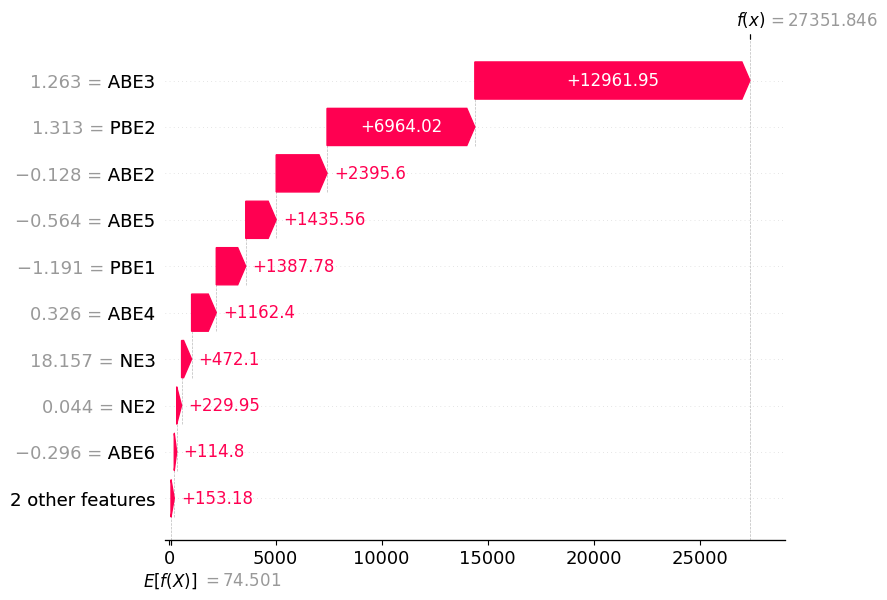

SHAP Waterfall Plot for Dependent Variable: highchol


100%|===================| 1997/1998 [16:32<00:00]        

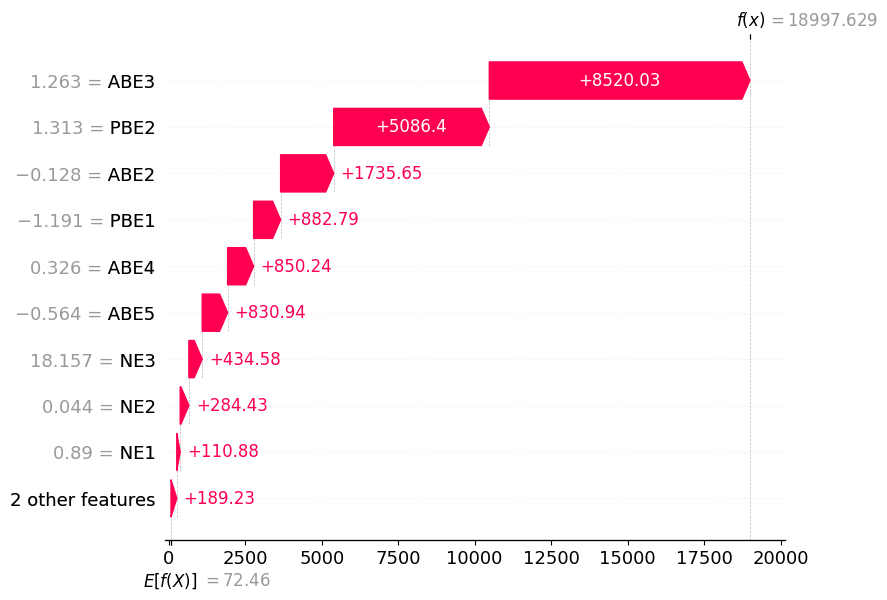

SHAP Waterfall Plot for Dependent Variable: obesity


In [12]:
top_percent = 1

for dep_var in dependent_vars:
    # Select all the rows by target value
    threshold = gdf[dep_var].quantile(1 - top_percent)
    top_data = gdf[gdf[dep_var] >= threshold]

    x = top_data[independent_vars]
    y = top_data[dep_var]

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=500, max_features=6, random_state=42)
    rf_model.fit(x, y)

    # SHAP Explanation
    explainer = shap.Explainer(rf_model, x)
    shap_values = explainer(x)

    # pick the sample with the largest total contribution
    idx_max = np.argmax(np.sum(np.abs(shap_values.values), axis=1))
    
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[idx_max].values,
        base_values=shap_values[idx_max].base_values,
        data=x.iloc[idx_max],
        feature_names=x.columns
    ))

    
    print(f'SHAP Waterfall Plot for Dependent Variable: {dep_var}')
    plt.show()

100%|===================| 1997/1998 [15:43<00:00]        

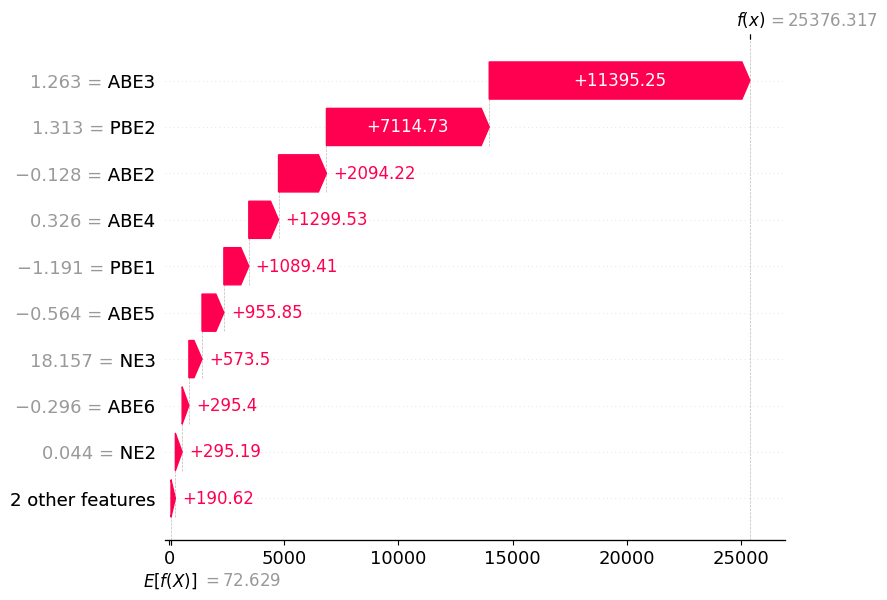

SHAP Waterfall Plot for Dependent Variable: bphigh


100%|===================| 1997/1998 [15:46<00:00]        

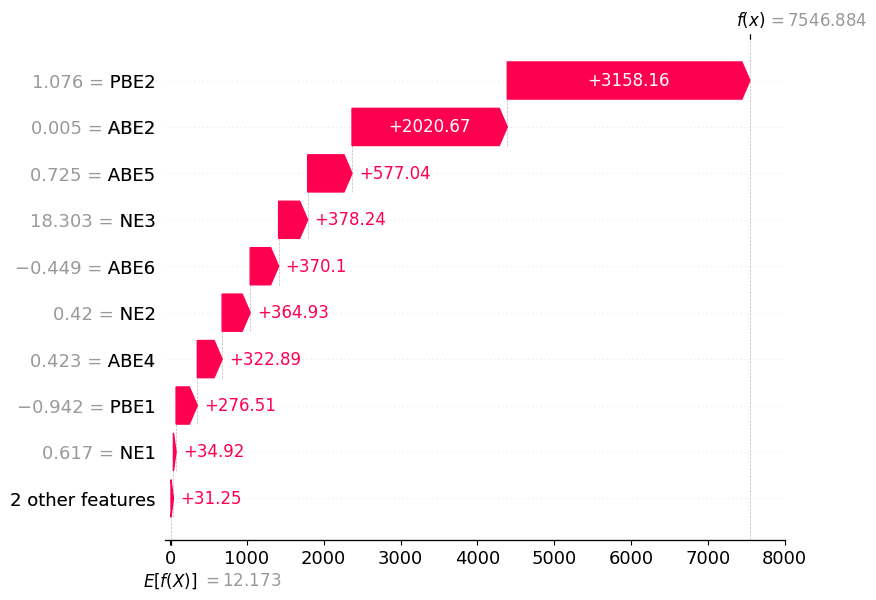

SHAP Waterfall Plot for Dependent Variable: chd


100%|===================| 1995/1998 [16:12<00:01]        

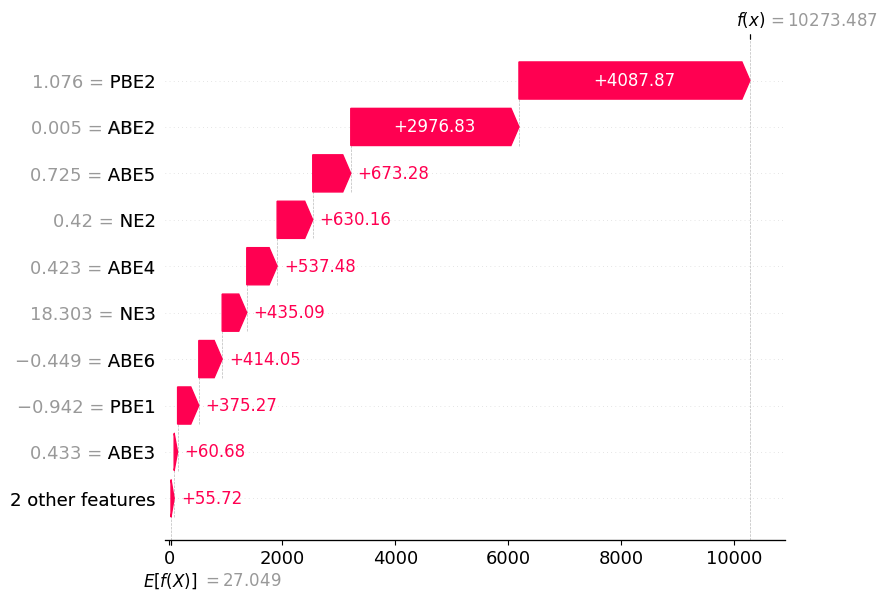

SHAP Waterfall Plot for Dependent Variable: diabetes


100%|===================| 1997/1998 [15:33<00:00]        

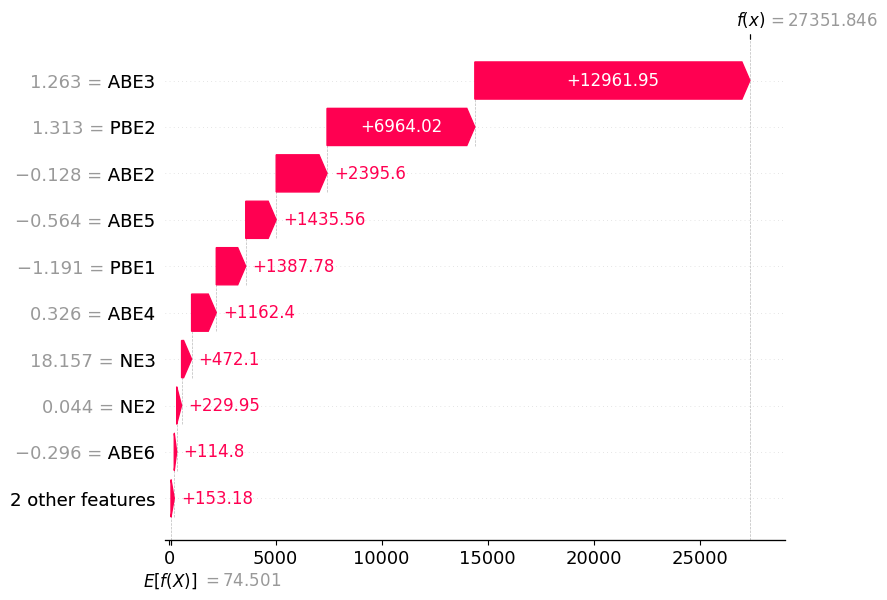

SHAP Waterfall Plot for Dependent Variable: highchol


100%|===================| 1997/1998 [16:20<00:00]        

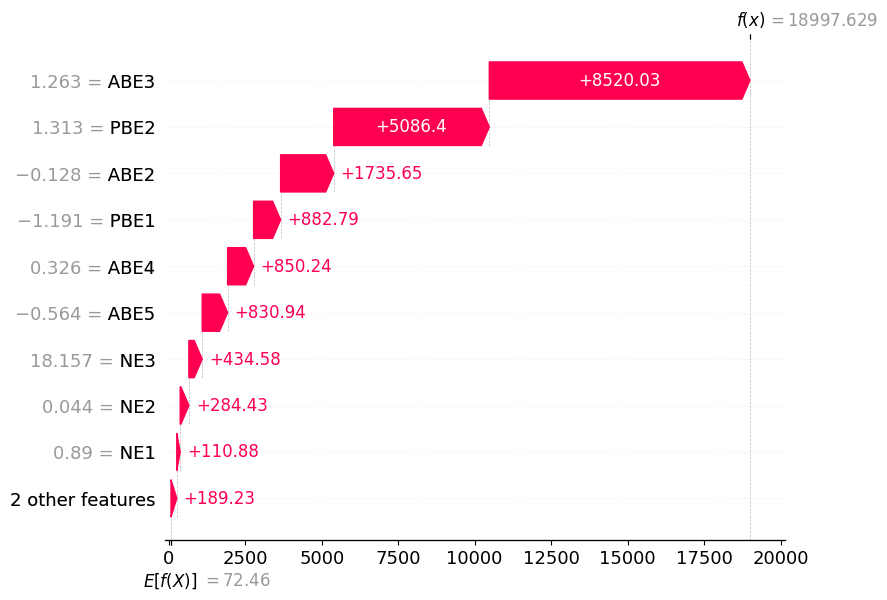

SHAP Waterfall Plot for Dependent Variable: obesity


In [13]:
top_percent = 1

for dep_var in dependent_vars:
    # Select all the rows by target value
    threshold = gdf[dep_var].quantile(1 - top_percent)
    top_data = gdf[gdf[dep_var] >= threshold]

    x = top_data[independent_vars]
    y = top_data[dep_var]

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=500, max_features=6, random_state=42)
    rf_model.fit(x, y)

    # SHAP Explanation
    explainer = shap.Explainer(rf_model, x)
    shap_values = explainer(x)

    idx_max_pred = shap_values.values.sum(axis=1).argmax()
    
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[idx_max_pred].values,
        base_values=shap_values[idx_max_pred].base_values,
        data=x.iloc[idx_max_pred],
        feature_names=x.columns
    ))

    print(f'SHAP Waterfall Plot for Dependent Variable: {dep_var}')
    plt.show()